In [20]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import bs4
import html5lib

bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))

bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']= 0

bitcoin_market_info['Volume']= bitcoin_market_info['Volume'].astype('int64')

bitcoin_market_info.head()
                                   
                

,Date,Open,High,Low,Close,Volume,Market Cap
0,2017-11-22,8077.95,8302.26,8075.47,8253.55,3633530000,134851000000
1,2017-11-21,8205.74,8348.66,7762.71,8071.26,4277610000,136967000000
2,2017-11-20,8039.07,8336.86,7949.36,8200.64,3488450000,134167000000
3,2017-11-19,7766.03,8101.91,7694.10,8036.49,3149320000,129595000000
4,2017-11-18,7697.21,7884.99,7463.44,7790.15,3667190000,128425000000


In [21]:
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]

eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
eth_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2017-11-22,360.31,381.42,360.15,380.65,800819000,34544000000
1,2017-11-21,367.44,372.47,350.69,360.40,949912000,35220200000
2,2017-11-20,354.09,372.14,353.29,366.73,807027000,33933400000
3,2017-11-19,347.40,371.29,344.74,354.39,1181530000,33284900000
4,2017-11-18,331.98,349.62,327.69,347.61,649639000,31800700000


In [22]:
bitcoin_market_info.columns = [bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns = [eth_market_info.columns[0]] + ['eth_' + i for i in eth_market_info.columns[1:]]

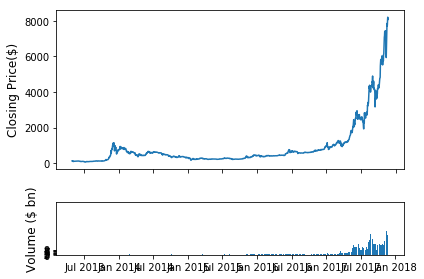

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax1.set_ylabel('Closing Price($)', fontsize=12)
ax2.set_ylabel('Volume ($ bn)', fontsize=12)
ax2.set_yticks([int('%d00000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013, 2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y') for i in range(2013, 2019) for j in[1,7]])
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['bt_Open'])
ax2.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Volume'].values)
fig.tight_layout()
#fig.figimage(bitcoin_im, 100, 120 ,zorder=3, alpha= .5)
plt.show()

In [24]:
market_info = pd.merge(bitcoin_market_info, eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-1']
for coins in ['bt_', 'eth_']:
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2017-11-22,8077.95,8302.26,8075.47,8253.55,3633530000,134851000000,360.31,381.42,360.15,380.65,800819000,34544000000,0.021738,0.056451
1,2017-11-21,8205.74,8348.66,7762.71,8071.26,4277610000,136967000000,367.44,372.47,350.69,360.40,949912000,35220200000,-0.016389,-0.019160
2,2017-11-20,8039.07,8336.86,7949.36,8200.64,3488450000,134167000000,354.09,372.14,353.29,366.73,807027000,33933400000,0.020098,0.035697
3,2017-11-19,7766.03,8101.91,7694.10,8036.49,3149320000,129595000000,347.40,371.29,344.74,354.39,1181530000,33284900000,0.034826,0.020121
4,2017-11-18,7697.21,7884.99,7463.44,7790.15,3667190000,128425000000,331.98,349.62,327.69,347.61,649639000,31800700000,0.012075,0.047081


In [25]:
for coins in ['bt_', 'eth_']:
    kwargs = { coins + 'close_off_high': lambda x: 2*(x[coins + 'High'] - x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
             coins + 'volatility': lambda x: (x[coins+'High']-x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [26]:
model_data= market_info[['Date']+[coin+metric for coin in ['bt_','eth_']
                                 for metric in ['Close', 'Volume', 'close_off_high','volatility']]]
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
691,2016-01-01,434.33,36278900,-0.560641,0.020292,0.948024,206062,-0.418477,0.025040
690,2016-01-02,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
689,2016-01-03,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
688,2016-01-04,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
687,2016-01-05,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


In [27]:
split_date = '2017-06-01'
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [28]:
window_len = 10
norm_cols = [coin+metric for coin in ['bt_', 'eth_'] for metric in ['Close', 'Volume']]

In [29]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] -1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1

In [30]:
LSTM_test_inputs = []
for i in range(len(test_set)- window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:,col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['eth_Close'][window_len:].values/test_set['eth_Close'][:-window_len].values) - 1

In [31]:
LSTM_training_inputs[0]

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
691,0.000000,0.000000,-0.560641,0.020292,0.000000,0.000000,-0.418477,0.025040
690,-0.002049,-0.170410,0.250597,0.009641,-0.011498,0.239937,0.965898,0.034913
689,-0.009946,0.092475,-0.173865,0.020827,0.025190,0.978201,-0.317885,0.060792
688,-0.002855,0.060603,-0.474265,0.012649,0.006810,0.680295,-0.057657,0.047943
687,-0.005457,-0.048411,-0.013333,0.010391,0.002270,0.066829,0.697930,0.025236
686,-0.012019,-0.061645,-0.003623,0.012782,0.002991,0.498534,-0.214540,0.026263
685,0.054613,1.413585,-0.951499,0.069045,-0.006349,2.142074,0.681644,0.040587
684,0.043515,0.570968,0.294196,0.032762,0.040890,1.647747,-0.806717,0.055274
683,0.030576,-0.110282,0.814194,0.017094,0.040937,0.098121,-0.411897,0.019021
682,0.031451,-0.007801,-0.919598,0.017758,0.054014,0.896944,-0.938235,0.025266


In [32]:
LSTM_training_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_training_inputs = np.array(LSTM_test_inputs)

In [33]:
LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [44]:
#import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout


def build_model(inputs, output_size, neurons, activ_func ="linear",
               dropout=0.25, loss= "mse", optimizer="adam"):
    model = Sequential()
    
    model.add(LSTM(neurons, input_shape=(inputs.shape[0], inputs.shape[1])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

###### np.random.seed(202)
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1

eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs,
                           epochs=50, batch_size=1, verbose=2, shuffle=True)

In [45]:
np.random.seed(202)
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values) -1
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs,
                           epochs=50, batch_size=1, verbose=2, shuffle=True)

ValueError: Error when checking input: expected lstm_5_input to have 3 dimensions, but got array with shape (10, 8)